In [1]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('arabic'))
from bs4 import BeautifulSoup
#import plotly.graph_objs as go
#import plotly.plotly as py
#import cufflinks
#from IPython.core.interactiveshell import InteractiveShell
#import plotly.figure_factory as ff
#InteractiveShell.ast_node_interactivity = 'all'
#from plotly.offline import iplot
#cufflinks.go_offline()
#cufflinks.set_config_file(world_readable=True, theme='pearl')

Using TensorFlow backend.


In [2]:
#readind and preparing data ( text , label )
import os, sys
import pandas as pd
import numpy as np
df=pd.read_excel('ml2.xlsx', header=None) ## read le file
df.columns=['tags','post']
print(df[1:5])

   tags                                               post
1    12  محضر تحقيق بالشكوى المقدمة بنك الشرق ضد جوزف ع...
2    13      حول ادعاء طوني يارد ضد مجهول بجرم سرقة محفظته
3    11  محضر تحقيق فوري بتوقيف اللبناني فارس ورده بجرم...
4    12  محضر تحقيق بإدعاء حسام حسين قبيسي ضد المدعى عل...


In [3]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9ا-ي #+_]')
STOPWORDS = set(stopwords.words('arabic'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    #text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['post'] = df['post'].apply(clean_text)

In [4]:
print(STOPWORDS)

{'ته', 'ليسا', 'ولو', 'متى', 'اللذين', 'لستما', 'هاتين', 'بكن', 'ذو', 'بما', 'حاشا', 'أما', 'فيما', 'كأي', 'مه', 'كم', 'منها', 'اللذان', 'هذان', 'خلا', 'إذما', 'إذن', 'ذه', 'أوه', 'فلا', 'غير', 'إليك', 'عند', 'كما', 'كي', 'لسنا', 'لولا', 'ذينك', 'تلك', 'على', 'آي', 'إليكن', 'لهن', 'تي', 'بماذا', 'اللواتي', 'كأين', 'الذي', 'لي', 'أنا', 'كل', 'كلاهما', 'وإذ', 'هذي', 'ذلك', 'بلى', 'أقل', 'تين', 'مهما', 'ثمة', 'عليه', 'أنتم', 'تلكما', 'ولكن', 'بيد', 'لسن', 'اللتين', 'ذان', 'إلا', 'عن', 'كذا', 'هذين', 'مع', 'ليسوا', 'ذات', 'ذي', 'أكثر', 'لكم', 'نحن', 'بها', 'اللائي', 'إذ', 'أيها', 'سوى', 'كلتا', 'يا', 'بعد', 'ليست', 'هاك', 'ذين', 'بس', 'فيم', 'لها', 'قد', 'كيفما', 'حيثما', 'ذلكم', 'لا', 'ذا', 'أو', 'هيا', 'حين', 'لم', 'بهن', 'بي', 'آه', 'إنا', 'بمن', 'لنا', 'هؤلاء', 'إنه', 'مذ', 'لاسيما', 'أولئك', 'لعل', 'إي', 'هي', 'لوما', 'من', 'أنتما', 'منه', 'ذواتي', 'هاتي', 'بهم', 'لكيلا', 'فيه', 'أنتن', 'ليس', 'هما', 'كأن', 'ومن', 'هاته', 'لدى', 'كذلك', 'نعم', 'أين', 'ليت', 'آها', 'ما', 'ذلكن', 'لكنما

In [7]:
# -*- coding: utf-8 -*-

# Arabic Transliteration based on Buckwalter
# dictionary source is buckwalter2unicode.py http://www.redhat.com/archives/fedora-extras-commits/2007-June/msg03617.html 

buck2uni = {"'": u"\u0621", # hamza-on-the-line
            "|": u"\u0622", # madda
            ">": u"\u0623", # hamza-on-'alif
            "&": u"\u0624", # hamza-on-waaw
            "<": u"\u0625", # hamza-under-'alif
            "}": u"\u0626", # hamza-on-yaa'
            "A": u"\u0627", # bare 'alif
            "b": u"\u0628", # baa'
            "p": u"\u0629", # taa' marbuuTa
            "t": u"\u062A", # taa'
            "v": u"\u062B", # thaa'
            "j": u"\u062C", # jiim
            "H": u"\u062D", # Haa'
            "x": u"\u062E", # khaa'
            "d": u"\u062F", # daal
            "*": u"\u0630", # dhaal
            "r": u"\u0631", # raa'
            "z": u"\u0632", # zaay
            "s": u"\u0633", # siin
            "$": u"\u0634", # shiin
            "S": u"\u0635", # Saad
            "D": u"\u0636", # Daad
            "T": u"\u0637", # Taa'
            "Z": u"\u0638", # Zaa' (DHaa')
            "E": u"\u0639", # cayn
            "g": u"\u063A", # ghayn
            "_": u"\u0640", # taTwiil
            "f": u"\u0641", # faa'
            "q": u"\u0642", # qaaf
            "k": u"\u0643", # kaaf
            "l": u"\u0644", # laam
            "m": u"\u0645", # miim
            "n": u"\u0646", # nuun
            "h": u"\u0647", # haa'
            "w": u"\u0648", # waaw
            "Y": u"\u0649", # 'alif maqSuura
            "y": u"\u064A", # yaa'
            "F": u"\u064B", # fatHatayn
            "N": u"\u064C", # Dammatayn
            "K": u"\u064D", # kasratayn
            "a": u"\u064E", # fatHa
            "u": u"\u064F", # Damma
            "i": u"\u0650", # kasra
            "~": u"\u0651", # shaddah
            "o": u"\u0652", # sukuun
            "`": u"\u0670", # dagger 'alif
            "{": u"\u0671", # waSla
}
def transString(string, reverse=0):
    '''Given a Unicode string, transliterate into Buckwalter. To go from
    Buckwalter back to Unicode, set reverse=1'''

    for k, v in buck2uni.items():
      if not reverse:
            string = string.replace(v, k)
      else:
            string = string.replace(k, v)

    return string


In [8]:
for i in range(len(df['post'])):
   df['post'][i]=transString(str(df['post'][i]))

C:\Users\Maya\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
print(df['post'][1:5])

1    mHDr tHqyq bAl$kwY Almqdmp bnk Al$rq Dd jwzf E...
2         Hwl AdEA Twny yArd Dd mjhwl bjrm srqp mHfZth
3    mHDr tHqyq fwry btwqyf AllbnAny fArs wrdh bjrm...
4    mHDr tHqyq bdEA HsAm Hsyn qbysy Dd AlmdEY Elyh...
Name: post, dtype: object


In [10]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['post'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 14825 unique tokens.


In [11]:
X = tokenizer.texts_to_sequences(df['post'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (7242, 250)


In [12]:
Y = pd.get_dummies(df['tags']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (7242, 13)


In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6517, 250) (6517, 13)
(725, 250) (725, 13)


In [14]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 13)                1313      
Total params: 5,081,713
Trainable params: 5,081,713
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Use tf.cast instead.
Train on 5865 samples, validate on 652 samples
Epoch 1/10
5865/5865 [==============================] - 36s 6ms/step - loss: 1.9979 - acc: 0.3693 - val_loss: 1.1482 - val_acc: 0.6135
Epoch 2/10
5865/5865 [==============================] - 36s 6ms/step - loss: 0.8892 - acc: 0.7079 - val_loss: 0.6109 - val_acc: 0.8175
Epoch 3/10
5865/5865 [==============================] - 36s 6ms/step - loss: 0.4842 - acc: 0.8523 - val_loss: 0.4537 - val_acc: 0.8589
Epoch 4/10
5865/5865 [==============================] - 37s 6ms/step - loss: 0.3457 - acc: 0.8977 - val_loss: 0.4133 - val_acc: 0.8819
Epoch 5/10
5865/5865 [==============================] - 36s 6ms/step - loss: 0.2233 - acc: 0.9419 - val_loss: 0.3941 - val_acc: 0.8896
Epoch 6/10
5865/5865 [==============================] - 38s 6ms/step - loss: 0.1704 - acc: 0.9555 - val_loss: 0.4043 - val_acc: 0.8896
Epoch 7/10
5865/5865 [==============================] - 37s 6ms/step - loss: 0.1224 - acc: 0.96

In [16]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

725/725 [==============================] - 1s 2ms/step
Test set
  Loss: 0.472
  Accuracy: 0.880


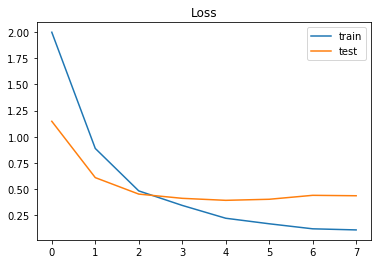

In [17]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

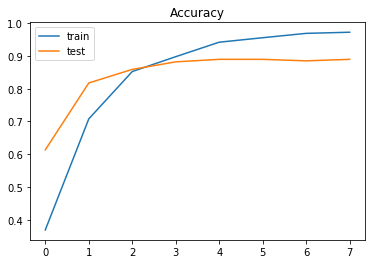

In [18]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();